# [?]-[GTSRB] - Dataset Analysis and Preparation
- Analyzing the GTSRB dataset and creating an improved dataset
# TODO

## Objectives:
- Gain an understanding of the complexities associated with data, especially when dealing with image data.
- Learn the process of constructing a simple and usable image dataset.

The German Traffic Sign Recognition Benchmark (GTSRB) is a dataset comprising over 50,000 photos of road signs categorized into approximately 40 classes. The ultimate goal is to recognize these signs!

A detailed description of the dataset can be found at: [http://benchmark.ini.rub.de/](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset)
# TODO

## Planned Steps:
- Understanding the dataset
- Preparing and formatting the enhanced data
- Saving the enhanced datasets in the h5 file format
# TODO

## 1. Imports & Constants & Methods
### 1. Import

In [68]:
import os  # For operating system related functionalities
import time  # For time-related functionalities
import sys  # For system-specific parameters and functions
import csv  # For reading and writing CSV files
import math  # For mathematical operations
import random  # For generating random numbers
import numpy as np  # For numerical operations on arrays
import pandas as pd  # For data manipulation and analysis
import matplotlib.pyplot as plt  # For creating plots and visualizations
import h5py  # For working with HDF5 files
import ipywidgets as widgets  # For creating interactive widgets in Jupyter Notebook
from IPython.display import display, Markdown  # For displaying outputs and Markdown text

import skimage  # For image processing operations
from skimage import io, color  # For reading and manipulating images

import tensorflow as tf  # For building and training machine learning models
from tensorflow import keras  # High-level API for TensorFlow
import json  # For working with JSON data
from IPython.display import display  # For displaying outputs in Jupyter Notebook

import warnings  # For ignoring warnings
warnings.filterwarnings("ignore")

### 1.2. Constants
Generating datasets can be a time and space-consuming process, taking approximately **10 minutes** and requiring **10 GB** of storage space.

To customize the dataset generation, you have the option to perform tests or generate the entire enhanced dataset by adjusting the following parameters:

- `dataset_generation_scale`: A value of 1 generates 100% of the dataset, while a value of 0.1 is suitable for testing purposes.
- `progress_verbosity`: Controls the level of verbosity for the progress bar. Use 0 for silence, 1 for a progress bar display, and 2 for a single-line display.
- `output_dir`: Specifies the directory where the enhanced dataset will be written. You can choose from the following options:
    - `./data`: Use this directory for testing purposes.
    - `<datasets_dir>/GTSRB/enhanced`: Use this directory to add clusters to your datasets directory.

To select the desired functionality, uncomment the appropriate lines according to your requirements.

Verbosity during training:
- 0: Silent mode, no output will be displayed during training.
- 1: Progress bar mode, a progress bar will be displayed to show the progress of each epoch.
- 2: One line per epoch mode, a concise summary will be displayed for each epoch.

In [69]:

# Test
# ----
#datasets = ['set-24x24-RGB']
#models        = {'v1':'get_model_v1', 'v2':'get_model_v2', 'v3':'get_model_v3'}
#batch_size    = 64
#epochs        = 5
#scale         = 0.1
#with_datagen  = False

# All possibilities
# ---- 
# datasets      = [set-24x24-RGB', 'set-48x48-RGB']
# models        = {'v1':'get_model_v1', 'v2':'get_model_v2', 'v3':'get_model_v3'}
# batch_size    = 64
# epochs        = 16
# scale         = 1
# with_datagen  = False

# Complete
# ---- 
datasets      = ['set-48x48-RGB']
models        = {'v2':'get_model_v2'}
batch_size    = 64
epochs        = 20
scale         = 1
with_datagen  = True

# Global
# ---- 
tag_id = '{}'.format(random.randint(0,99999))

# Verbosity
# ----
verbosity = 2

# Patch

# ----
run_dir = './run' 
data_output_dir = './data' 
project_gtsrb_path = "/kaggle/input/gtsrb-german-traffic-sign"


### 1.3. Methods

In [ ]:
# ------------------------------------------------ #
# Global Methods
# ------------------------------------------------ #
    
# ---------------- #    
# Images
# ---------------- #    

def preprocess_images(images, width=25, height=25):
    '''
    Resize and convert images - doesn't change originals.
    input images must be RGBA or RGB.
    Note: all outputs are fixed-size numpy arrays of float64.
    
    Args:
        images: list of images
        width, height: new image size (default: 25x25)
        
    Returns:
        numpy array of enhanced images
    '''
    out = []
    
    loading_max = len(images)
    progress_bar = widgets.IntProgress(min=0, max=loading_max, bar_style='info')
    display(progress_bar) 
        
    for i, img in enumerate(images):
        
        # If RGBA, convert to RGB
        if img.shape[2] == 4:
            img = color.rgba2rgb(img)
            
        # Resize
        img = transform.resize(img, (width, height))

        # Add image to the list
        out.append(img)
        progress_bar.value = i + 1
    progress_bar.close()

    # Reshape images
    out = np.array(out, dtype='float64')
    out = out.reshape(-1, width, height, 3)
    
    return out


# ---------------- #    
# Show 
# ---------------- # 

def show_text(heading_level, text):
    '''
    Display a markdown heading or bold text
    args:
        heading_level : heading level (h1, h2, h3, h4, h5, b)
        text : text to display
    return:
        none
    '''
    # Switch the heading level
    # ----
    if heading_level == 'h1':
        display(Markdown(f'# {text}'))
    elif heading_level == 'h2':
        display(Markdown(f'## {text}'))
    elif heading_level == 'h3':
        display(Markdown(f'### {text}'))
    elif heading_level == 'h4':
        display(Markdown(f'#### {text}'))
    elif heading_level == 'h5':
        display(Markdown(f'##### {text}'))
    elif heading_level == 'b':
        display(Markdown(f'**{text}**'))
    else:
        display(Markdown(f'{text}'))
        
def show_data_and_sample_images(samples):
    show_text("b",'Data')
    show_images(
        x_train,
        y_train, 
        samples, 
        columns=10, 
        figure_size=(2,2), 
        show_colorbar=False, 
        y_pred=None, 
        color_map='binary'
    )
    show_text("b",'Meta')
    show_images(
        x_meta,
        y_meta, 
        y_train[samples], 
        columns=10, 
        figure_size=(2,2), 
        show_colorbar=False, 
        y_pred=None, 
        color_map='binary'
    )
    
    
def show_images(
    x, 
    y=None, 
    indices='all', 
    columns=12, 
    figure_size=(1, 1),                
    show_colorbar=False, 
    y_pred=None, 
    color_map='binary',
    normalization=None, 
    padding=0.35, 
    spines_alpha=1, 
    font_size=20,
    interpolation='lanczos'
):
    """
    Display a grid of images with labels.

    Args:
        x: The images to display. Shapes must be (-1, lx, ly), (-1, lx, ly, 1), or (-1, lx, ly, 3).
        y: Real classes or labels associated with the images. (None)
        indices: Indices of images to show or 'all' for all images. ('all')
        columns: Number of columns in the grid. (12)
        figure_size: Size of the figure (width, height). (1, 1)
        show_colorbar: Whether to show the colorbar. (False)
        y_pred: Predicted classes associated with the images. (None)
        color_map: Matplotlib color map to use. ('binary')
        normalization: Matplotlib imshow normalization. (None)
        padding: Padding between rows in the grid. (0.35)
        spines_alpha: Alpha value for the spines. (1)
        font_size: Font size in pixels. (20)
        interpolation: Interpolation method for displaying the images. ('lanczos')

    Returns:
        None
    """
    if indices == 'all':
        indices = range(len(x))

    if normalization and len(normalization) == 2:
        normalization = matplotlib.colors.Normalize(vmin=normalization[0], vmax=normalization[1])

    draw_labels = (y is not None)
    draw_predicted_labels = (y_pred is not None)

    rows = math.ceil(len(indices) / columns)
    fig = plt.figure(figsize=(columns * figure_size[0], rows * (figure_size[1] + padding)))

    n = 1
    for i in indices:
        axs = fig.add_subplot(rows, columns, n)
        n += 1

        # Shape is (lx,ly)
        # ----
        if len(x[i].shape) == 2:
            xx = x[i]
        # Shape is (lx,ly,n)
        # ----
        if len(x[i].shape) == 3:
            (lx, ly, lz) = x[i].shape
            if lz == 1:
                xx = x[i].reshape(lx, ly)
            else:
                xx = x[i]

        img = axs.imshow(xx, cmap=color_map, norm=normalization, interpolation=interpolation)

        axs.spines['right'].set_visible(True)
        axs.spines['left'].set_visible(True)
        axs.spines['top'].set_visible(True)
        axs.spines['bottom'].set_visible(True)

        axs.spines['right'].set_alpha(spines_alpha)
        axs.spines['left'].set_alpha(spines_alpha)
        axs.spines['top'].set_alpha(spines_alpha)
        axs.spines['bottom'].set_alpha(spines_alpha)

        axs.set_yticks([])
        axs.set_xticks([])

        if draw_labels and not draw_predicted_labels:
            axs.set_xlabel(y[i], fontsize=font_size)
        if draw_labels and draw_predicted_labels:
            if y[i] != y_pred[i]:
                axs.set_xlabel(f'{y_pred[i]} ({y[i]})', fontsize=font_size)
                axs.xaxis.label.set_color('red')
            else:
                axs.set_xlabel(y[i], fontsize=font_size)

        if show_colorbar:
            fig.colorbar(img, orientation="vertical", shrink=0.65)

    plt.show()
    
# ---------------- #     
# Dataset 
# ---------------- # 

def save_h5_dataset(x_train, y_train, x_test, y_test, x_meta,y_meta, filename):
        
    # Create h5 file
    # ----
    with h5py.File(filename, "w") as f:
        f.create_dataset("x_train", data=x_train)
        f.create_dataset("y_train", data=y_train)
        f.create_dataset("x_test",  data=x_test)
        f.create_dataset("y_test",  data=y_test)
        f.create_dataset("x_meta",  data=x_meta)
        f.create_dataset("y_meta",  data=y_meta)
        
    # Print
    # ----
    size=os.path.getsize(filename)/(1024*1024)
    print('Dataset : {:24s}  shape : {:22s} size : {:6.1f} Mo   (saved)'.format(filename, str(x_train.shape),size))

def read_dataset(enhanced_dir, dataset_name):
    '''Reads h5 dataset from dataset_dir
    Args:
        dataset_dir : datasets dir
        name        : dataset name, without .h5
    Returns:    x_train,y_train,x_test,y_test data'''
    # ---- Read dataset
    filename = f'{enhanced_dir}/{dataset_name}.h5'
    size     = os.path.getsize(filename)/(1024*1024)

    with  h5py.File(filename,'r') as f:
        x_train = f['x_train'][:]
        y_train = f['y_train'][:]
        x_test  = f['x_test'][:]
        y_test  = f['y_test'][:]

    # ---- Shuffle
    x_train,y_train=shuffle_np_dataset(x_train,y_train)

    # ---- done
    return x_train,y_train,x_test,y_test,size

def shuffle_np_dataset(*data):
    """
    Shuffle a list of dataset
    args:
        *data : datasets
    return:
        *datasets mixed
    """
    # Ramdomize
    # ----
    p = np.random.permutation(len(data[0]))
    out = [ d[p] for d in data ]
    return out[0] if len(out)==1 else out



def rescale_dataset(*data, scale=1):
    '''
    Rescale numpy array with 'scale' factor
    args:
        *data : arrays
        scale : scale factor
    return:
        arrays of rescaled data
    '''
    print('Datasets have been resized with a factor ', scale)
    out = [ d[:int(scale*len(d))] for d in data ]
    return out[0] if len(out)==1 else out

# ---------------- #     
# Dir 
# ---------------- # 

def mkdir(path):
    '''
    Create a subdirectory
    Mode is 0750, do nothing if exist
    args:
        path : directory to create
    return:
        none
    '''
    os.makedirs(path, mode=0o750, exist_ok=True)
    
# ---------------- # 
# Road signs
# ---------------- # 
def read_csv_and_extract_road_sign_images_with_labels(csv_file): 
    '''
    Reads traffic sign data from German Traffic Sign Recognition Benchmark dataset.
    Arguments:  
        csv filename :  Description file, Example /data/GTSRB/Train.csv
    Returns:
        x,y          :  np array of images, np array of corresponding labels
    '''

    path = os.path.dirname(csv_file)
    name = os.path.basename(csv_file)

    # Read csv file
    df = pd.read_csv(csv_file, header=0)
    
    # Get filenames and ClassIds
    filenames = df['Path'].to_list()
    y = df['ClassId'].to_list()
    x = []
    
    # Read images
    loading_max = len(filenames)
    progress_bar = IntProgress(min=0, max=loading_max, bar_style='info')
    display(progress_bar)
    
    for i, filename in enumerate(filenames):
        image = io.imread(os.path.join(path, filename))
        x.append(image)
        progress_bar.value = i + 1
    
    progress_bar.close()
    
    return np.array(x, dtype=object), np.array(y)

## 3. Read the dataset

In this step, we will be working with a traffic sign recognition benchmark dataset, which you can find more information about [here](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

Each directory in this dataset contains a CSV file with annotations titled `GT-<ClassID>.csv` along with training images. The CSV file includes the following fields:

- Filename
- Width
- Height
- Roi.X1
- Roi.Y1
- Roi.X2
- Roi.Y2
- ClassId

These fields correspond to the file name of the image, the dimensions of the image, the coordinates of the region of interest, and the class ID of the traffic sign, respectively.

### 3.1. Understanding the Dataset Structure

The dataset is structured in the following way: The root directory **\<dataset_dir\>/GTSRB/origine** contains three main subsets: **Train**, **Test**, and **Meta**.

Each of these subsets includes a CSV file that contains the image annotations, and a corresponding directory filled with image files.

By understanding the layout and structure of the dataset, we can effectively load, preprocess, and use this data for model training and testing.

In [71]:
df = pd.read_csv(f'{project_gtsrb_path}/Test.csv', header=0)
display(df.head(10))

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png
5,52,56,5,5,47,51,38,Test/00005.png
6,147,130,12,12,135,119,18,Test/00006.png
7,32,33,5,5,26,28,12,Test/00007.png
8,45,50,6,5,40,45,25,Test/00008.png
9,81,86,7,7,74,79,35,Test/00009.png


### 3.2. Data Loading and Preparation

In this step, we will be loading the following subsets of our dataset:

- **Train** subset: This forms our training dataset, which will be used to train the model. We'll refer to the input and output data as `x_train` and `y_train` respectively.
- **Test** subset: This is our validation dataset, used to evaluate the performance of the model during and after training. The input and output data for this subset will be referred to as `x_test` and `y_test`.
- **Meta** subset: This subset is primarily used for visualization purposes to understand the data better. The input and output data for this subset will be referred to as `x_meta` and `y_meta`.

We'll shuffle the training data to ensure that our model isn't influenced by the order of the examples. Meanwhile, the visualization data (Meta) will be sorted to facilitate effective and easier analysis.

In [72]:
# ---- Read datasets

(x_train,y_train) = read_csv_and_extract_road_sign_images_with_labels(f'{project_gtsrb_path}/Train.csv')
(x_test ,y_test)  = read_csv_and_extract_road_sign_images_with_labels(f'{project_gtsrb_path}/Test.csv')
(x_meta ,y_meta)  = read_csv_and_extract_road_sign_images_with_labels(f'{project_gtsrb_path}/Meta.csv')
    
# ---- Shuffle train set

x_train, y_train = shuffle_np_dataset(x_train, y_train)

# ---- Sort Meta

combined = list(zip(x_meta,y_meta))
combined.sort(key=lambda x: x[1])
x_meta,y_meta = zip(*combined)

IntProgress(value=0, bar_style='info', max=39209)

IntProgress(value=0, bar_style='info', max=12630)

IntProgress(value=0, bar_style='info', max=43)

## 4. Analyzing the Training Dataset
It is essential to understand the nature of the images in our training dataset. Homogeneity, in terms of size, ratio, width, and height, can significantly impact the effectiveness of the model.

### 4.1. Conducting Statistical Analysis
We will perform a statistical analysis to understand the distribution and characteristics of the images in our training dataset. This analysis will provide insights into the uniformity of the images' size, their aspect ratio, and their dimensions (width and height). A balanced and homogeneous dataset tends to perform better in training machine learning models, and this analysis will help us understand how well our dataset meets these criteria.

In [73]:
train_size  = []
train_ratio = []
train_lx    = []
train_ly    = []

test_size   = []
test_ratio  = []
test_lx     = []
test_ly     = []

for image in x_train:
    (lx,ly,lz) = image.shape
    train_size.append(lx*ly/1024)
    train_ratio.append(lx/ly)
    train_lx.append(lx)
    train_ly.append(ly)

for image in x_test:
    (lx,ly,lz) = image.shape
    test_size.append(lx*ly/1024)
    test_ratio.append(lx/ly)
    test_lx.append(lx)
    test_ly.append(ly)
    
# Displaying Dataset Shapes
print(f"Shape of x_train: {x_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of x_test: {x_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of x_train: (39209,)
Shape of y_train: (39209,)
Shape of x_test: (12630,)
Shape of y_test: (12630,)


#### 4.2. Conducting Statistical Analysis of Distributions

In this section, we will perform a statistical analysis of the distributions present in our Kaggle dataset. The goal is to gain insights into the data and identify:

- Size Statistics
- Aspect Ratio Statistics 
- Width
- Height
- Class ID


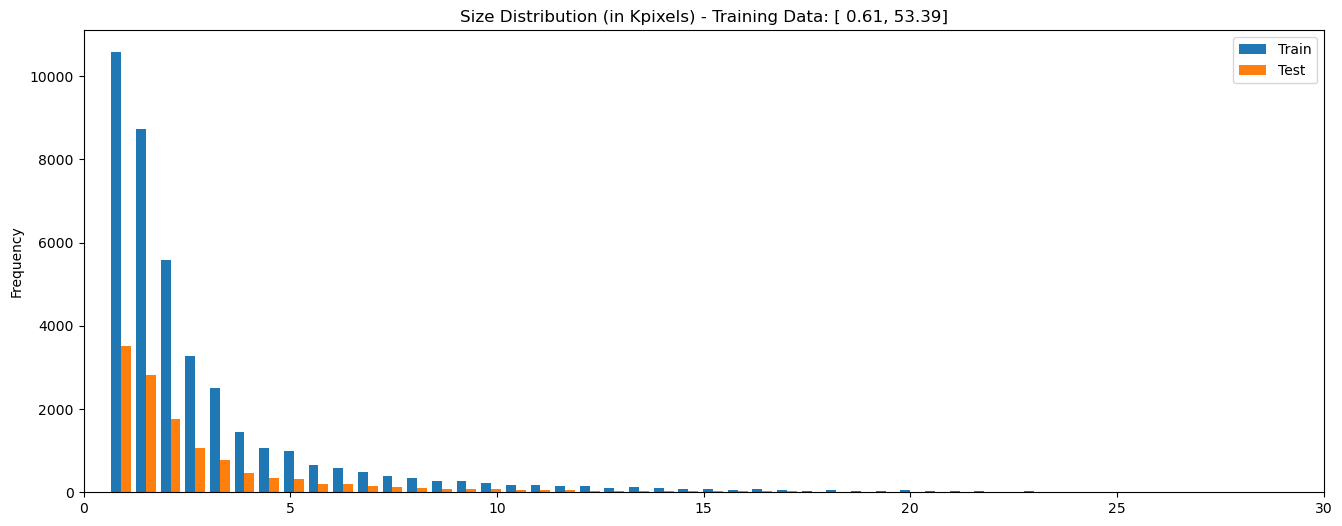

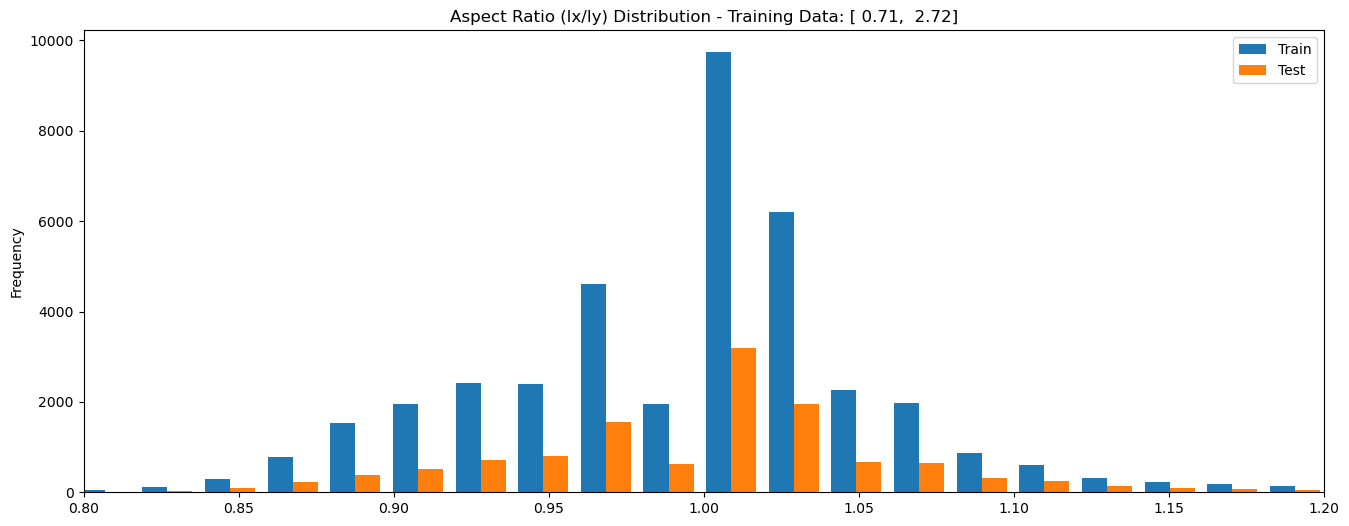

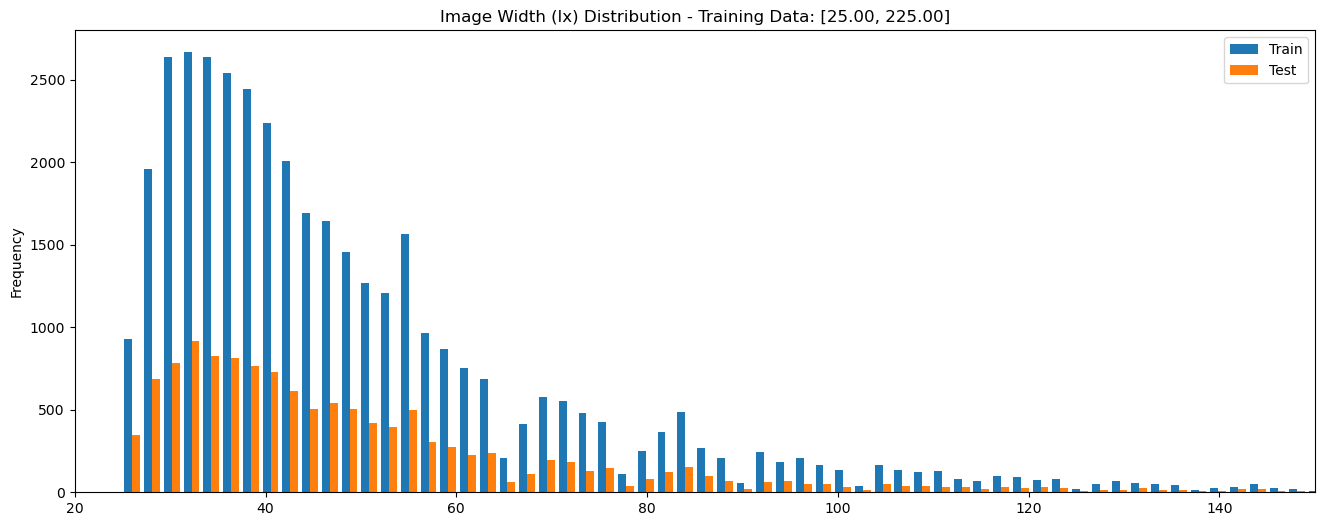

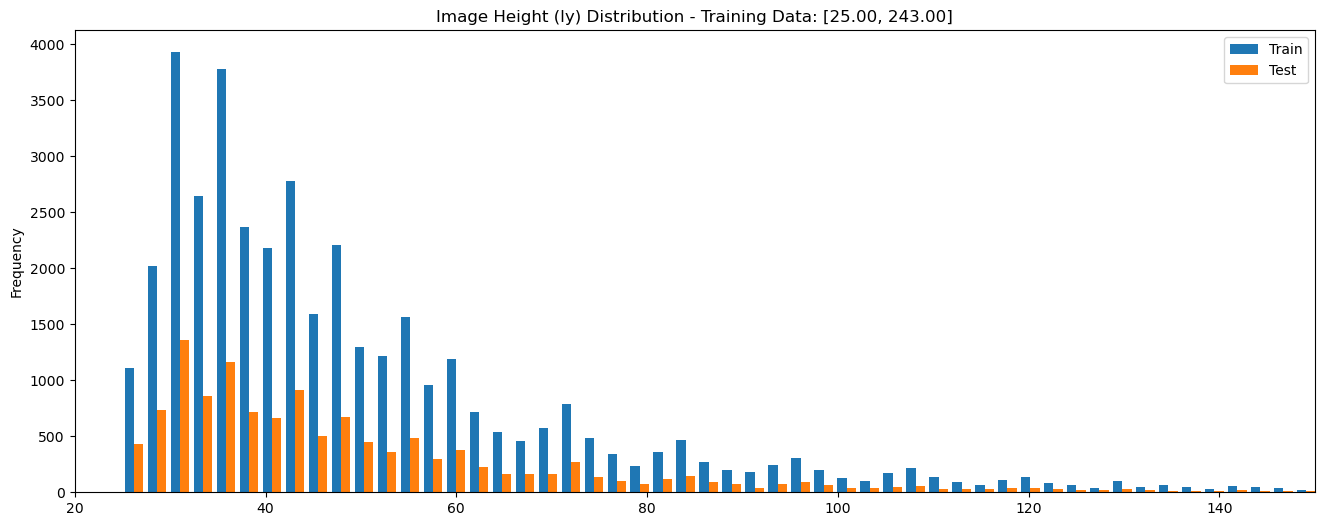

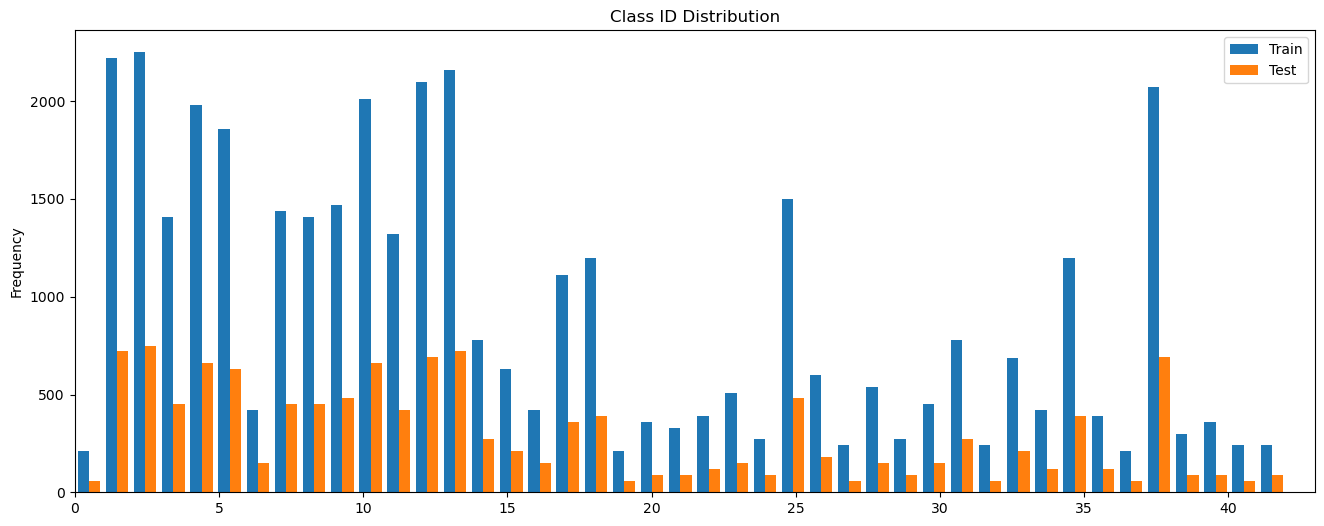

In [74]:
# Size Statistics
# ----
plt.figure(figsize=(16,6))
plt.hist([train_size,test_size], bins=100)
plt.gca().set(title=f'Size Distribution (in Kpixels) - Training Data: [{min(train_size):5.2f}, {max(train_size):5.2f}]', 
              ylabel='Frequency', xlim=[0,30])
plt.legend(['Train','Test'])
plt.show()

# Aspect Ratio Statistics (lx/ly)
# ----
plt.figure(figsize=(16,6))
plt.hist([train_ratio,test_ratio], bins=100)
plt.gca().set(title=f'Aspect Ratio (lx/ly) Distribution - Training Data: [{min(train_ratio):5.2f}, {max(train_ratio):5.2f}]', 
              ylabel='Frequency', xlim=[0.8,1.2])
plt.legend(['Train','Test'])
plt.show()

# Width (lx) Statistics
# ----
plt.figure(figsize=(16,6))
plt.hist([train_lx,test_lx], bins=100)
plt.gca().set(title=f'Image Width (lx) Distribution - Training Data: [{min(train_lx):5.2f}, {max(train_lx):5.2f}]', 
              ylabel='Frequency', xlim=[20,150])
plt.legend(['Train','Test'])
plt.show()

# Height (ly) Statistics
# ----
plt.figure(figsize=(16,6))
plt.hist([train_ly,test_ly], bins=100)
plt.gca().set(title=f'Image Height (ly) Distribution - Training Data: [{min(train_ly):5.2f}, {max(train_ly):5.2f}]', 
              ylabel='Frequency', xlim=[20,150])
plt.legend(['Train','Test'])
plt.show()

# Class ID Distribution
# ----
plt.figure(figsize=(16,6))
plt.hist([y_train,y_test], bins=43)
plt.gca().set(title='Class ID Distribution', ylabel='Frequency', xlim=[0,43])
plt.legend(['Train','Test'])
plt.show()


## 5. Exploring the Image Classes

In this section, we will delve into understanding the 43 distinct classes that our images fall into. These classes represent different types of traffic signs, and each class is denoted by a unique class ID. Gaining a clear understanding of these categories will assist us in later stages of model training and prediction.

### 5.1. Exploring the Meta Image Classes

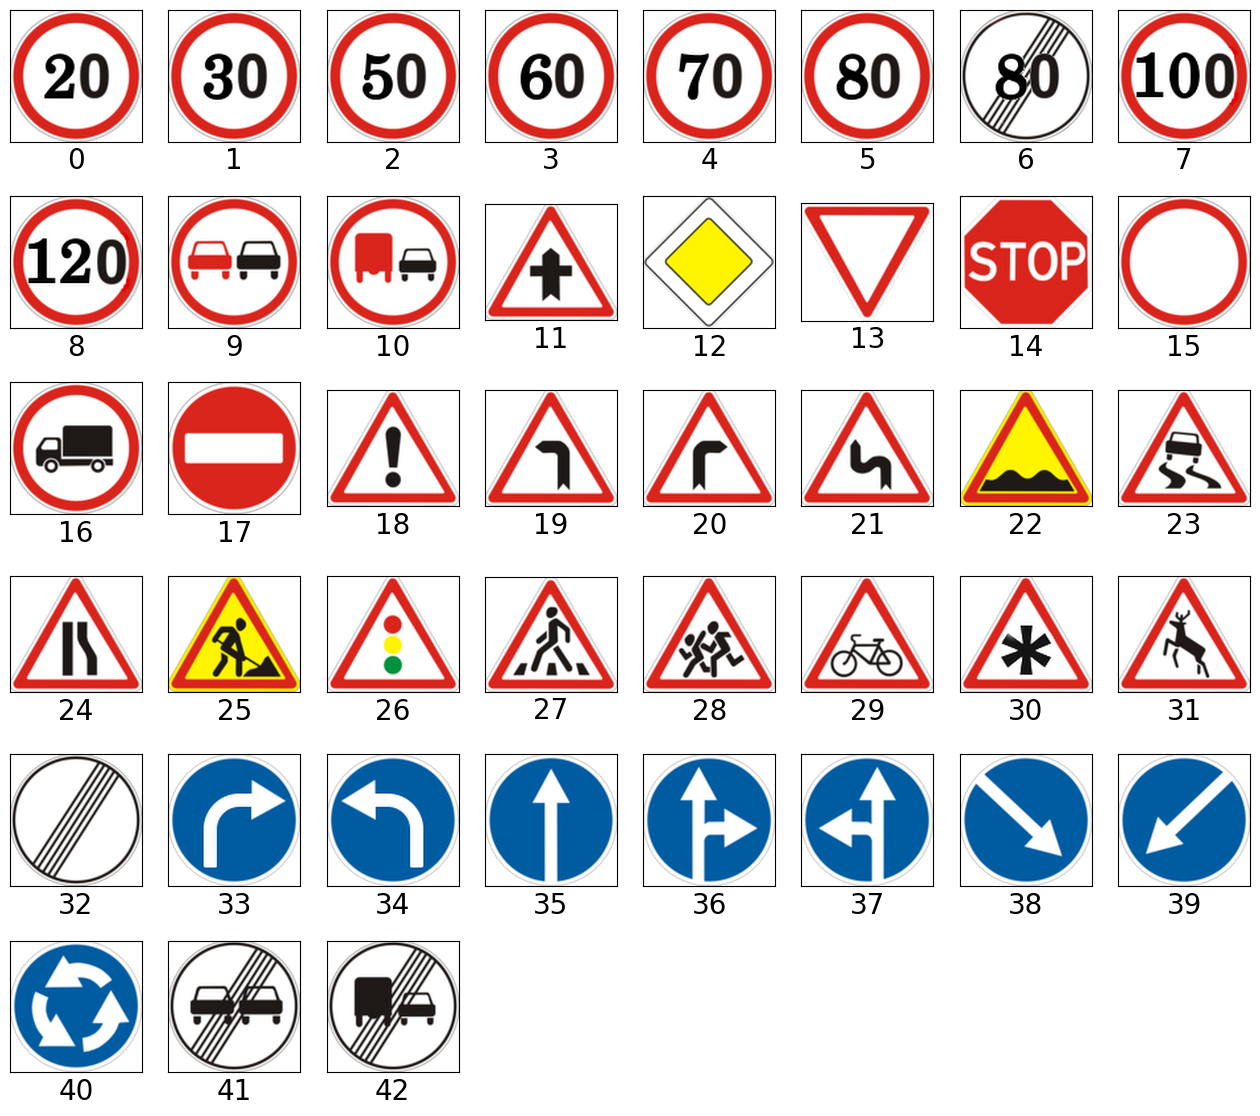

In [75]:
show_images(
    x_meta,
    y_meta, 
    range(43), 
    columns=8, 
    figure_size=(2,2), 
    show_colorbar=False, 
    y_pred=None, 
    color_map='binary'
)

### 5.2. Exploring the Data Image Classes

In this step, we aim to gain a visual understanding of our dataset. By inspecting the actual images from each class, we can have a more tangible grasp of what the traffic signs in our dataset look like, enhancing our understanding of the data we are working with.

**Data**

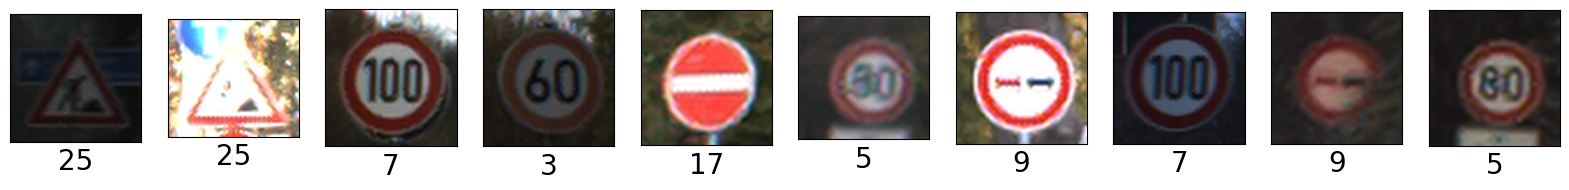

**Meta**

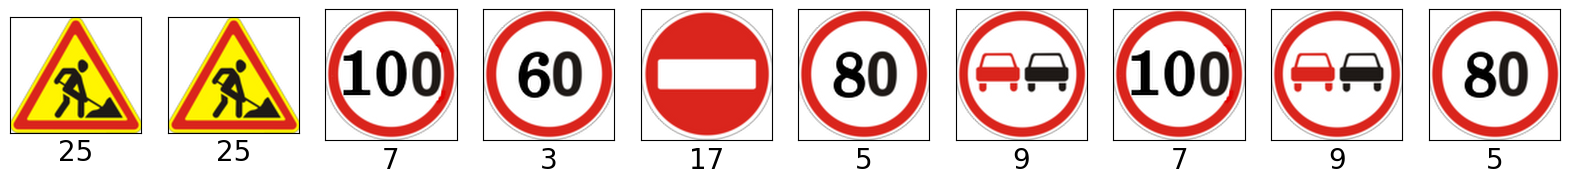

**Data**

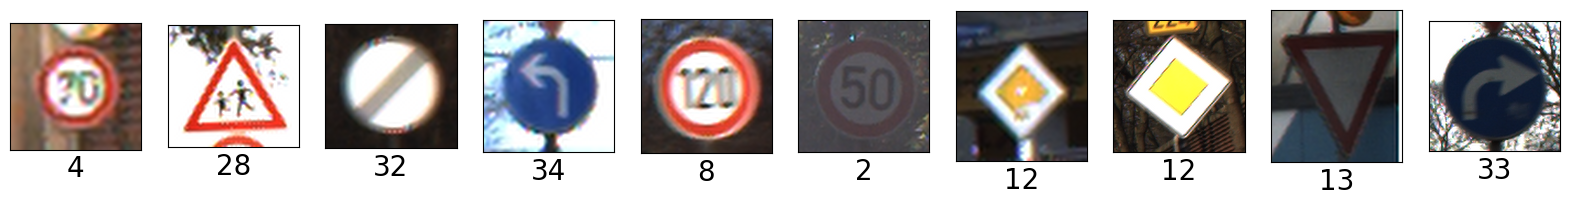

**Meta**

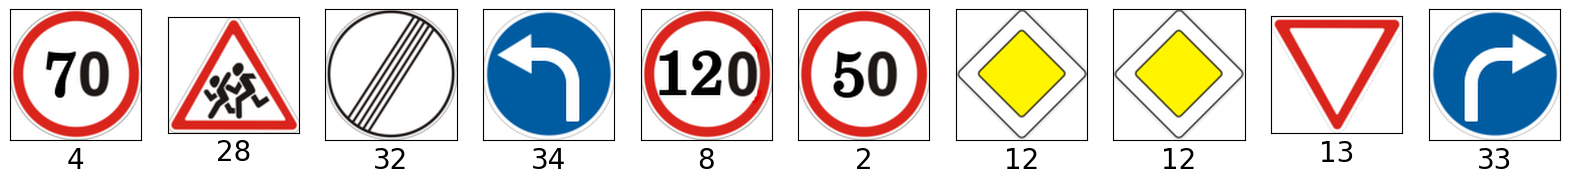

In [76]:
samples = [random.randint(0,len(x_train)-1) for i in range(10)]    
show_data_and_sample_images(samples)

samples = [random.randint(0,len(x_train)-1) for i in range(10)]    
show_data_and_sample_images(samples)

## 7. Preprocessing the Dataset

For successful training of our model, the images in our dataset need to satisfy certain criteria. These include:

- **Uniform Size**: The images must all have the same dimensions to match the input requirements of the neural network model.
- **Normalization**: The pixel values of the images should be normalized to fall within a specific range, typically between 0 and 1. This aids in speeding up the training process and achieving better performance.

We choose to work with either **RGB** (colored)

### 7.1. Enhancing Images Through Preprocessing

In this section, we will implement various preprocessing steps to enhance our images before the training process. These steps include normalization, resizing.

This will allow us to visualize the effects of image enhancement techniques on these samples.

IntProgress(value=0, bar_style='info', max=16)

**EXPECTED**

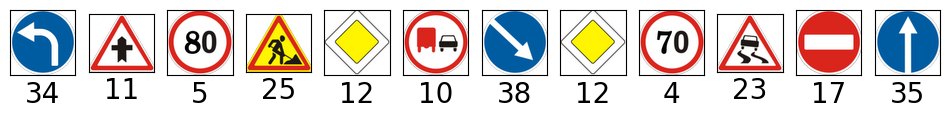

**ORIGINAL**

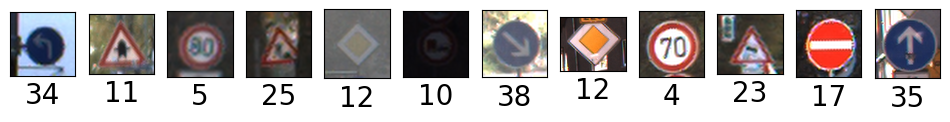

**ENHANCED**

Dataset: RGB  min,max=[0.028,1.000]  shape=(16, 25, 25, 3)


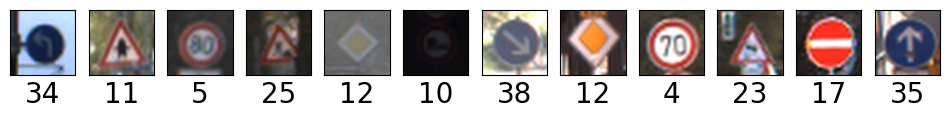

In [77]:
# Randomly select 16 samples
i = random.randint(0, len(x_train) - 16)
x_samples = x_train[i:i+16]
y_samples = y_train[i:i+16]

# Apply image enhancement for different modes
datasets = preprocess_images(x_samples, width=25, height=25)

# Display expected images
show_text("b", 'EXPECTED')
x_expected = [x_meta[i] for i in y_samples]
show_images(
    x_expected, 
    y_samples, 
    range(12), 
    columns=12, 
    figure_size=(1, 1),
    show_colorbar=False, 
    y_pred=None, 
    color_map='binary'
)

# Display original images
show_text("b", 'ORIGINAL')
show_images(
    x_samples, 
    y_samples, 
    range(12), 
    columns=12, 
    figure_size=(1, 1),
    show_colorbar=False, 
    y_pred=None, 
    color_map='binary'
)

# Display enhanced images for each dataset
show_text("b", 'ENHANCED')
print("Dataset: RGB  min,max=[{:.3f},{:.3f}]  shape={}".format(datasets.min(), datasets.max(), datasets.shape))
show_images(
    datasets, 
    y_samples, 
    range(12), 
    columns=12, 
    figure_size=(1, 1),
    show_colorbar=False, 
    y_pred=None, 
    color_map='binary'
)


### 7.3. Generate enhanced Datasets
In this section, we will generate enhanced datasets by applying feature engineering techniques to the existing data.

Comment: Feature engineering is an important step in any machine learning project as it helps in creating new features or transforming existing ones to improve the performance of the models.


In [90]:
n_train = int(len(x_train)*scale )
n_test  = int(len(x_test)*scale )

show_text("b",'Parameters :')
print(f'Scale is : {scale}')
print(f'x_train length is : {n_train}')
print(f'x_test  length is : {n_test}')
print(f'output dir is     : {data_output_dir}\n')

mkdir(data_output_dir)

datasets = []
for s in [24, 48]:
    filename = f'{data_output_dir}/set-{s}x{s}-RGB.h5'
    datasets.append(f"set-{s}x{s}-RGB")
    show_text("b",f'Dataset : {filename}')
    # Enhancement
    #      Note : x_train is a numpy array of python objects (images with <> sizes)
    #             but images_enhancement() return a real array of float64 numpy (images with same size)
    #             so, we can save it in nice h5 files
    #
    x_train_new = preprocess_images( x_train[:n_train], width=s, height=s)
    x_test_new  = preprocess_images( x_test[:n_test],  width=s, height=s)
    x_meta_new  = preprocess_images( x_meta,  width=s, height=s)
        
    # ---- Save
    save_h5_dataset(x_train_new, y_train[:n_train], x_test_new, y_test[:n_test], x_meta_new,y_meta, filename)
    x_train_new, x_test_new=0,0
        



**Parameters :**

Scale is : 1
x_train length is : 39209
x_test  length is : 12630
output dir is     : ./data



**Dataset : ./data/set-24x24-RGB.h5**

IntProgress(value=0, bar_style='info', max=39209)

IntProgress(value=0, bar_style='info', max=12630)

IntProgress(value=0, bar_style='info', max=43)

Dataset : ./data/set-24x24-RGB.h5   shape : (39209, 24, 24, 3)     size :  684.4 Mo   (saved)


**Dataset : ./data/set-48x48-RGB.h5**

IntProgress(value=0, bar_style='info', max=39209)

IntProgress(value=0, bar_style='info', max=12630)

IntProgress(value=0, bar_style='info', max=43)

Dataset : ./data/set-48x48-RGB.h5   shape : (39209, 48, 48, 3)     size : 2736.4 Mo   (saved)


### 7.2. Preview of Enhancing Images

**Dataset : ./data/set-24x24-RGB.h5 from h5 file.**

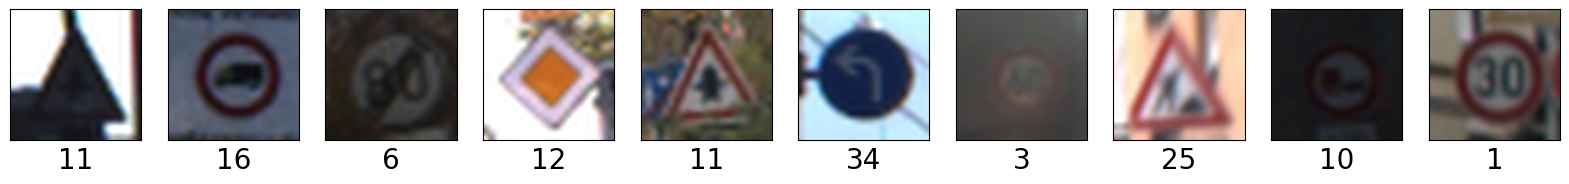

**Dataset : ./data/set-48x48-RGB.h5 from h5 file.**

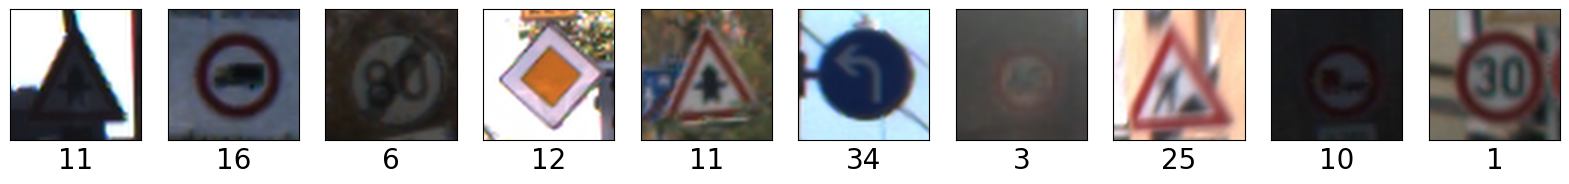

In [91]:
samples=range(10)

for s in [24, 48]:
    filename = f'{data_output_dir}/set-{s}x{s}-RGB.h5'
    with  h5py.File(filename,'r') as f:
        x_tmp = f['x_train'][:]
        y_tmp = f['y_train'][:]
        show_text("b",f'Dataset : {filename} from h5 file.')
        show_images(
            x_tmp,
            y_tmp, 
            samples, 
            columns=10, 
            figure_size=(2,2), 
            show_colorbar=False, 
            y_pred=None, 
            color_map='binary'
        )
    x_tmp,y_tmp=0,0

BLa

In [92]:
# A basic model
#
def get_model_v1(lx,ly,lz):
    
    model = keras.models.Sequential()
    
    model.add( keras.layers.Conv2D(96, (3,3), activation='relu', input_shape=(lx,ly,lz)))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(192, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Flatten()) 
    model.add( keras.layers.Dense(1500, activation='relu'))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Dense(43, activation='softmax'))
    return model
    
# A more sophisticated model
#
def get_model_v2(lx,ly,lz):
    model = keras.models.Sequential()

    model.add( keras.layers.Conv2D(64, (3, 3), padding='same', input_shape=(lx,ly,lz), activation='relu'))
    model.add( keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add( keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(256, (3, 3), padding='same',activation='relu'))
    model.add( keras.layers.Conv2D(256, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Flatten())
    model.add( keras.layers.Dense(512, activation='relu'))
    model.add( keras.layers.Dropout(0.5))
    model.add( keras.layers.Dense(43, activation='softmax'))
    return model

def get_model_v3(lx,ly,lz):
    model = keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(32, (5, 5), padding='same',  activation='relu', input_shape=(lx,ly,lz)))
    model.add(tf.keras.layers.BatchNormalization(axis=-1))      
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.2))

    model.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same',  activation='relu'))
    model.add(tf.keras.layers.BatchNormalization(axis=-1))
    model.add(tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation='relu'))
    model.add(tf.keras.layers.BatchNormalization(axis=-1))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.2))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(512, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.4))

    model.add(tf.keras.layers.Dense(43, activation='softmax'))
    return model

In [93]:
def multi_run(enhanced_dir, datasets, models, datagen=None,
              scale=1, batch_size=64, epochs=16, 
              verbosity=0, tag_id='last'):
    """
    Launches a dataset-model combination
    args:
        enhanced_dir   : Directory of the enhanced datasets
        datasets       : List of dataset (whitout .h5)
        models         : List of model like { "model name":get_model(), ...}
        datagen        : Data generator or None (None)
        scale          : % of dataset to use.  1 mean all. (1)
        batch_size     : Batch size (64)
        epochs         : Number of epochs (16)
        verbosity  : Verbose level (0)
        tag_id         : postfix for report, logs and models dir (_last)
    return:
        report        : Report as a dict for Pandas.
    """  
    # ---- Logs and models dir
    #
    os.makedirs(f'{run_dir}/logs_{tag_id}',   mode=0o750, exist_ok=True)
    os.makedirs(f'{run_dir}/models_{tag_id}', mode=0o750, exist_ok=True)
    
    # ---- Columns of output
    #
    output={}
    output['Dataset'] = []
    output['Size']    = []
    for m in models:
        output[m+'_Accuracy'] = []
        output[m+'_Duration'] = []

    # ---- Let's go
    #
    for d_name in datasets:
        print("\nDataset : ",d_name)

        # ---- Read dataset
        x_train,y_train,x_test,y_test, d_size = read_dataset(enhanced_dir, d_name)
        output['Dataset'].append(d_name)
        output['Size'].append(d_size)
        
        # ---- Rescale
        x_train,y_train,x_test,y_test = rescale_dataset(x_train,y_train,x_test,y_test, scale=scale)
        
        # ---- Get the shape
        (n,lx,ly,lz) = x_train.shape

        # ---- For each model
        for m_name,m_function in models.items():
            print("    Run model {}  : ".format(m_name), end='')
            # ---- get model
            try:
                # ---- get function by name
                m_function=globals()[m_function]
                model=m_function(lx,ly,lz)
                # ---- Compile it
                model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
                # ---- Callbacks tensorboard
                log_dir = f'{run_dir}/logs_{tag_id}/tb_{d_name}_{m_name}'
                tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
                # ---- Callbacks bestmodel
                save_dir = f'{run_dir}/models_{tag_id}/model_{d_name}_{m_name}.h5'
                bestmodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, monitor='accuracy', save_best_only=True)
                # ---- Train
                start_time = time.time()
                if datagen==None:
                    # ---- No data augmentation (datagen=None) --------------------------------------
                    history = model.fit(x_train, y_train,
                                        batch_size      = batch_size,
                                        epochs          = epochs,
                                        verbose         = verbosity,
                                        validation_data = (x_test, y_test),
                                        callbacks       = [tensorboard_callback, bestmodel_callback])
                else:
                    # ---- Data augmentation (datagen given) ----------------------------------------
                    datagen.fit(x_train)
                    history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                                        steps_per_epoch = int(len(x_train)/batch_size),
                                        epochs          = epochs,
                                        verbose         = verbosity,
                                        validation_data = (x_test, y_test),
                                        callbacks       = [tensorboard_callback, bestmodel_callback])
                    
                # ---- Result
                end_time = time.time()
                duration = end_time-start_time
                accuracy = max(history.history["val_accuracy"])*100
                #
                output[m_name+'_Accuracy'].append(accuracy)
                output[m_name+'_Duration'].append(duration)
                print(f"Accuracy={accuracy: 7.2f}    Duration={duration: 7.2f}")
            except:
                print('An error occured for :',m_name)
                output[m_name+'_Accuracy'].append('0')
                output[m_name+'_Duration'].append('999')
                print('-')
    return output

In [ ]:
# ---- Data augmentation or not
#
if with_datagen :
    datagen = keras.preprocessing.image.ImageDataGenerator(featurewise_center=False,
                                                           featurewise_std_normalization=False,
                                                           width_shift_range=0.1,
                                                           height_shift_range=0.1,
                                                           zoom_range=0.2,
                                                           shear_range=0.1,
                                                           rotation_range=10.)
else:
    datagen=None
    
# ---- Run
#
output = multi_run(data_output_dir,
                   datasets, 
                   models,
                   datagen       = datagen,
                   scale         = scale,
                   batch_size    = batch_size,
                   epochs        = epochs,
                   verbosity = verbosity,
                   tag_id        = tag_id)

# ---- Save report
#
report={}
report['output']=output
report['description'] = f'scale={scale} batch_size={batch_size} epochs={epochs} data_aug={with_datagen}'

report_name=f'{run_dir}/report_{tag_id}.json'

with open(report_name, 'w') as file:
    json.dump(report, file, indent=4)

print('\nReport saved as ',report_name)

print('-'*59)


Dataset :  set-24x24-RGB
Datasets have been resized with a factor  1
    Run model v1  : Epoch 1/5
613/613 - 89s - loss: 0.9630 - accuracy: 0.7224 - val_loss: 0.3616 - val_accuracy: 0.9035 - 89s/epoch - 145ms/step
Epoch 2/5
613/613 - 88s - loss: 0.1549 - accuracy: 0.9548 - val_loss: 0.2759 - val_accuracy: 0.9319 - 88s/epoch - 143ms/step
Epoch 3/5
613/613 - 99s - loss: 0.0845 - accuracy: 0.9761 - val_loss: 0.2127 - val_accuracy: 0.9470 - 99s/epoch - 161ms/step
Epoch 4/5
613/613 - 83s - loss: 0.0627 - accuracy: 0.9819 - val_loss: 0.2004 - val_accuracy: 0.9456 - 83s/epoch - 136ms/step
Epoch 5/5
613/613 - 83s - loss: 0.0463 - accuracy: 0.9868 - val_loss: 0.2331 - val_accuracy: 0.9468 - 83s/epoch - 135ms/step
Accuracy=  94.70    Duration= 443.58
    Run model v2  : Epoch 1/5
613/613 - 245s - loss: 2.0475 - accuracy: 0.4021 - val_loss: 0.4857 - val_accuracy: 0.8454 - 245s/epoch - 399ms/step
Epoch 2/5
613/613 - 236s - loss: 0.3150 - accuracy: 0.8966 - val_loss: 0.2435 - val_accuracy: 0.9375 

In [ ]:
def highlight_max(s):
    is_max = (s == s.max())
    return ['background-color: yellow' if v else '' for v in is_max]

def show_report(file):
    # ---- Read json file
    with open(file) as infile:
        dict_report = json.load( infile )
    output      = dict_report['output']
    description = dict_report['description']
    # ---- about
    show_text("h1",f'Report : {Path(file).stem}')
    print(    "Desc.  : ",description,'\n')
    # ---- Create a pandas
    report       = pd.DataFrame (output)
    col_accuracy = [ c for c in output.keys() if c.endswith('Accuracy')]
    col_duration = [ c for c in output.keys() if c.endswith('Duration')]
    # ---- Build formats
    lambda_acc = lambda x : '{:.2f} %'.format(x) if (isinstance(x, float)) else '{:}'.format(x)
    lambda_dur = lambda x : '{:.1f} s'.format(x) if (isinstance(x, float)) else '{:}'.format(x)
    formats = {'Size':'{:.2f} Mo'}
    for c in col_accuracy:   
        formats[c]=lambda_acc
    for c in col_duration:
        formats[c]=lambda_dur
    t=report.style.highlight_max(subset=col_accuracy).format(formats).hide_index()
    display(t)
    
import pandas as pd
import sys,os,glob,json
from pathlib import Path
from IPython.display import display, Markdown

report_dir = './run/'

for file in glob.glob(f'{report_dir}/*.json'):
    show_report(file)